In [1]:
from glob import glob
import ast

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
from PIL.PngImagePlugin import PngInfo

In [2]:
DATA_DIR = "../samples/" # images saved using aerial_image_dataset_generator.py
DRONE_RADIUS = 1 # used to generate a kernel for cost map

# Files filtered according to the sensor type
depth_samples = sorted(glob(DATA_DIR+'*depth*.png'))
rgb_samples = sorted(glob(DATA_DIR+'*rgb*.png'))
instance_segmentation_samples = sorted(glob(DATA_DIR+'*segment*.png'))

## Choose an index to test

In [3]:
img_idx = 86

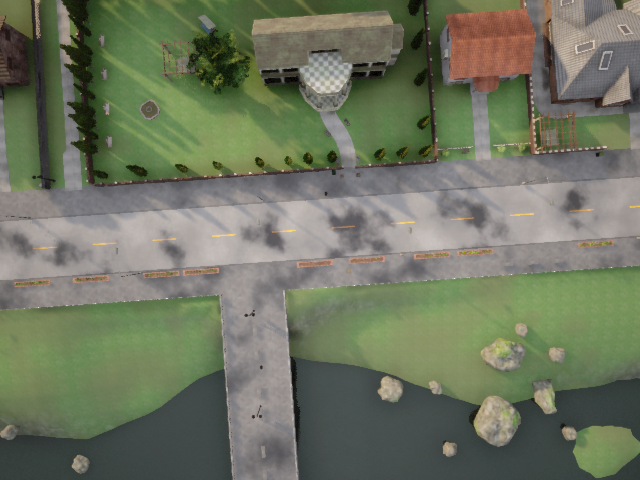

In [4]:
img_rgb = Image.open(rgb_samples[img_idx])
img_rgb

# Instance segmentation
https://carla.readthedocs.io/en/latest/ref_sensors/#sensor.camera.instance_segmentation
* Files are saved as BGR
* RGB values: [semantic tag, instance_id_high, instance_id_low]

In [5]:
semantic_labels = {
0: 'Unlabeled',     # Elements that have not been categorized are considered Unlabeled. 
                    # This category is meant to be empty or at least contain elements with no collisions.
1: 'Building',      # Buildings like houses, skyscrapers,... and the elements attached to them.
                    # E.g. air conditioners, scaffolding, awning or ladders and much more.
2: 'Fence',         # Barriers, railing, or other upright structures. 
                    # Basically wood or wire assemblies that enclose an area of ground.
3: 'Other',         # Everything that does not belong to any other category.
4: 'Pedestrian',    # Humans that walk or ride/drive any kind of vehicle or mobility system.
                    # E.g. bicycles or scooters, skateboards, horses, roller-blades, wheel-chairs, etc.
5: 'Pole',          # Small mainly vertically oriented pole. If the pole has a horizontal part (often for traffic light poles) this is also considered pole.
                    # E.g. sign pole, traffic light poles.
6: 'RoadLine',      # The markings on the road.
7: 'Road',          # Part of ground on which cars usually drive.
                    # E.g. lanes in any directions, and streets.
8: 'SideWalk',      # Part of ground designated for pedestrians or cyclists. Delimited from the road by some obstacle (such as curbs or poles), not only by markings. This label includes a possibly delimiting curb, traffic islands (the walkable part), and pedestrian zones.
9: 'Vegetation',    # Trees, hedges, all kinds of vertical vegetation. Ground-level vegetation is considered Terrain.
10: 'Vehicles',     # Cars, vans, trucks, motorcycles, bikes, buses, trains.
11: 'Wall',         # Individual standing walls. Not part of a building.
12: 'TrafficSign',  # Signs installed by the state/city authority, usually for traffic regulation. This category does not include the poles where signs are attached to.
                    # E.g. traffic- signs, parking signs, direction signs...
13: 'Sky',          # Open sky. Includes clouds and the sun.
14: 'Ground',       # Any horizontal ground-level structures that does not match any other category. For example areas shared by vehicles and pedestrians, or flat roundabouts delimited from the road by a curb.
15: 'Bridge',       # Only the structure of the bridge. Fences, people, vehicles, an other elements on top of it are labeled separately.
16: 'RailTrack',    # All kind of rail tracks that are non-drivable by cars.
                    # E.g. subway and train rail tracks.
17: 'GuardRail',    # All types of guard rails/crash barriers.
18: 'TrafficLight', # Traffic light boxes without their poles.
19: 'Static',       # Elements in the scene and props that are immovable.
                    # E.g. fire hydrants, fixed benches, fountains, bus stops, etc.
20: 'Dynamic',      # Elements whose position is susceptible to change over time.
                    # E.g. Movable trash bins, buggies, bags, wheelchairs, animals, etc.
21: 'Water',        # Horizontal water surfaces.
                    # E.g. Lakes, sea, rivers.
22: 'Terrain',      # Grass, ground-level vegetation, soil or sand. 
                    # These areas are not meant to be driven on. This label includes a possibly delimiting curb.
}


script_hash: 713fa72b73ee942823a44bb66fc6c70258583462f737717f7cb9d1ed01710261
TOTAL_SAMPLES: 100
YAW_LIMITS: (-90, 90)
Z_LIMITS: (50, 100)
SEED: 42
FOV: 69
XYZYAW: (235, 133, 64, -85)
WEATHER_PRESET: WetCloudyNoon
sun_azimuth_angle: 39.0
sun_altitude_angle: 25.0


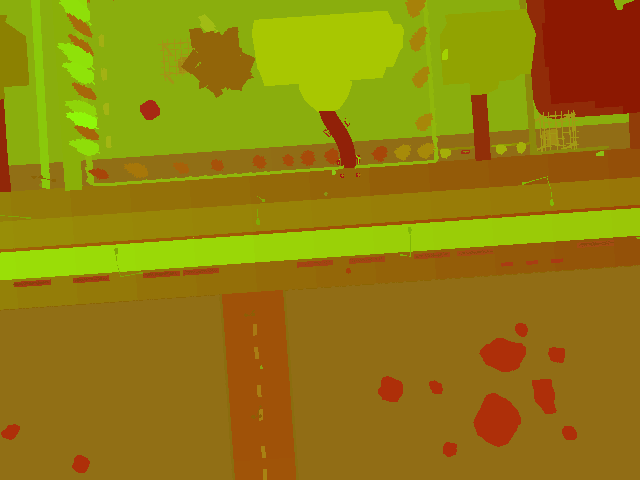

In [6]:
img = Image.open(instance_segmentation_samples[img_idx])

# Print metadata with details about the data collection
for ti in img.text:
    print(f"{ti}: {img.text[ti]}")

curr_pos_yaw = ast.literal_eval(img.text['XYZYAW'])
fov = ast.literal_eval(img.text['FOV'])

view_width = img.size[0]
view_height = img.size[1]

calibration = np.identity(3)
calibration[0, 2] = view_width / 2
calibration[1, 2] = view_height / 2
calibration[0, 0] = calibration[1, 1] = view_width / (2 * np.tan((fov*np.pi/180)/2))

# The same classes show as different colors because
# it's an instance segmentation with the instance id
# represented as Green and Blue.
# The class id is encoded into the R, but the image was saved as BGR
img

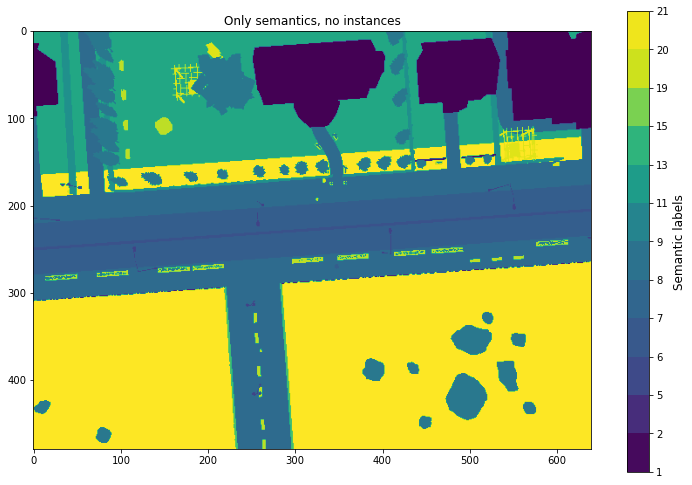

In [7]:
only_semantics = np.array(img)[...,2]
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,8))
cax = ax.imshow(only_semantics)
ax.set_title('Only semantics, no instances')

# Add colorbar, make sure to specify tick locations to match desired ticklabels
ticks = list(set(only_semantics.flatten()))
# cbar = fig.colorbar(cax, ticks=ticks)
# cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, ticks=ticks, boundaries=ticks, format='%1i')
ax2.set_ylabel('Semantic labels', size=12)
plt.show()

### Define what a good place to land is by filtering the known bad places to land

In [8]:
PLACES2LAND = ["Terrain", "Ground", "Other", "SideWalk", "Unlabeled", "Static", "Sky"]

# Everything that is not a good place to land on is an obstacle here
obstacle_ids = [i for i in semantic_labels if semantic_labels[i] not in PLACES2LAND]

In [9]:
[semantic_labels[i] for i in obstacle_ids]

['Building',
 'Fence',
 'Pedestrian',
 'Pole',
 'RoadLine',
 'Road',
 'Vegetation',
 'Vehicles',
 'Wall',
 'TrafficSign',
 'Bridge',
 'RailTrack',
 'GuardRail',
 'TrafficLight',
 'Dynamic',
 'Water']

#### Visualize the obstacles

In [10]:
# The instance segmentation is saved as BGR
# and the class id is encoded into the R
# img_rgb = np.array(img)[:,:,::-1]
img_mono = np.array(img)[...,2]

# There's no class id 255, so 
# we use 255 to mark the obstacles
for i in obstacle_ids:
    img_mono[img_mono==i] = 255

# After that we change everything that is not an obstacle to 0
img_mono[img_mono!=255] = 0

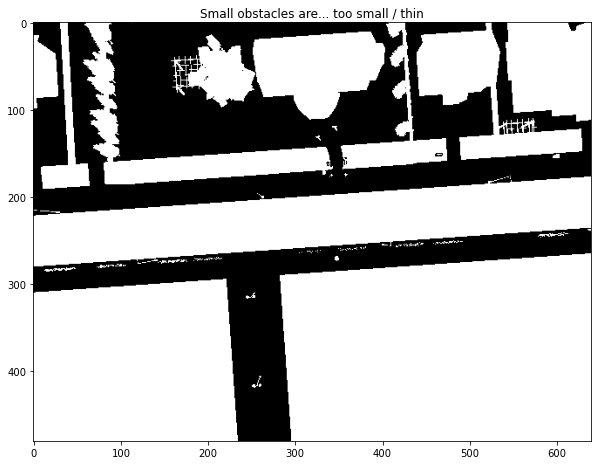

In [11]:
# 255 (obstacles) will show as white and 0 (place good to land on) as black
plt.figure(figsize=(10,8))
plt.imshow(img_mono, cmap='gray')
plt.title("Small obstacles are... too small / thin")
plt.show()

### Apply a dilation to obstacles

In [12]:
DILATION = 1
img_mono = np.array(img)[...,2]

# Slicing the image according to the obstacles
# to make the dilation easier (?!?)
img_mono_dilated = np.zeros(img_mono.shape)
for i in obstacle_ids:
    tmp_img = img_mono.copy()
    # Keep only the current obstacle class (1), 
    # everything else becomes 0
    tmp_img[tmp_img!=i] = 0
    tmp_img[tmp_img==i] = 1
    
    # Apply a dilation
    tmp_img = np.array(Image.fromarray(tmp_img).filter(ImageFilter.MaxFilter(DILATION)))
    #tmp_img = np.array(Image.fromarray(tmp_img).filter(ImageFilter.GaussianBlur(DILATION)))
    
    # save this slice
    img_mono_dilated += tmp_img

# The dilation will "leak" over different places because the size 
# of the obstacle in the slice will increase.
# To keep it binary, everything that is not 0 (place good to land on)
# will be turned into 1, fusing all obstacles
img_mono_dilated[img_mono_dilated>0] = 1

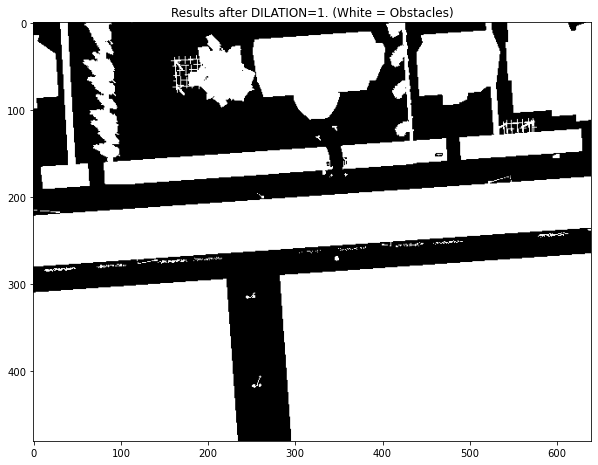

In [13]:
plt.figure(figsize=(10,8))
plt.imshow(img_mono_dilated, cmap='gray')
plt.title(f"Results after DILATION={DILATION}. (White = Obstacles)")
plt.show()

### Add to obstacle layer all free space too small for a drone to land on

It will be necessary to infer a radius (in pixels) for the drone and project that onto the image plan.

In [14]:
from scipy import signal

In [15]:
def create_drone_patch(w,h):
    # based on https://stackoverflow.com/a/44874588/7658422
    center = (int(w/2), int(h/2))
    radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    drone_patch = (dist_from_center <= radius)+0
    return drone_patch

In [16]:
# Altitude used for sampling (dataset generation)
_,_,z,_ = curr_pos_yaw

# Get image plane coordinates for a square with side 2xDRONE_RADIUS at dist=z
# using an approximating as a pinhole camera
img_plane = np.dot(calibration,[2*DRONE_RADIUS,2*DRONE_RADIUS,z])*np.array([1/z, 1/z, 1])

# Rounds it up
drone_patch_shape = np.ceil(abs(calibration[0:2,-1]-img_plane[[0,1]])).astype(int)

# Generates the patch 'kernel' (image plane)
drone_patch = create_drone_patch(*drone_patch_shape)

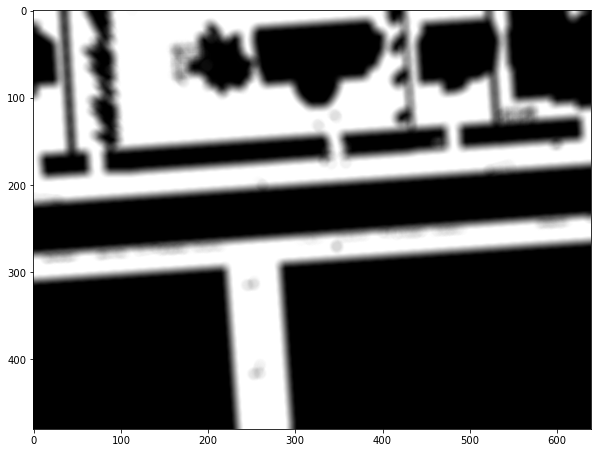

In [17]:
# Make change obstacle value to 0
img_mono_dilated_inv = np.invert(img_mono_dilated==1)+0

# Calculate correlation of the drone_path over the mask.
# It will blur the landing areas reducing its size to account
# for the size of the drone.
corr_res = signal.correlate2d(img_mono_dilated_inv, drone_patch, boundary='symm', mode='same')

# Normalize it so the only good places to land will have value 1
corr_res = corr_res/corr_res.max()

plt.figure(figsize=(10,8))
plt.imshow(corr_res, cmap='gray')
plt.show()

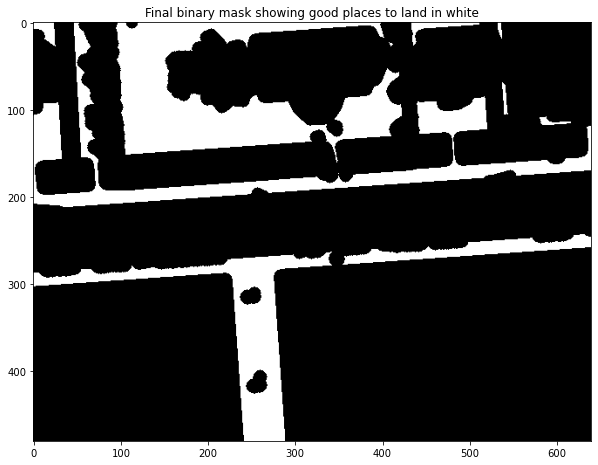

In [18]:
# All areas with a value smaller than one mean
# the drone patch didn't fit perfectly.
# Therefore, we will threshold to make a binary mask
corr_res_thrs = corr_res.copy()
corr_res_thrs[corr_res_thrs<1] = 0

plt.figure(figsize=(10,8))
plt.imshow(corr_res_thrs, cmap='gray')
plt.title("Final binary mask showing good places to land in white")
plt.show()

### The drone is located at the centre of the image
The final cost map needs to take into account the area of nice spots to land and the distance to the drone.

* Contour area: the bigger the area, the easier to land
* Contour perimeter/area: will tell how complex the contour is, and it's better to land on simple ones
* The distance to the pixel inside a contour should be part of the cost as well

Now we need to transform the mask into something that gradient descent could be used to find a place to land.

In [19]:
import cv2

In [20]:
mask = (corr_res_thrs*255).astype('uint8')
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

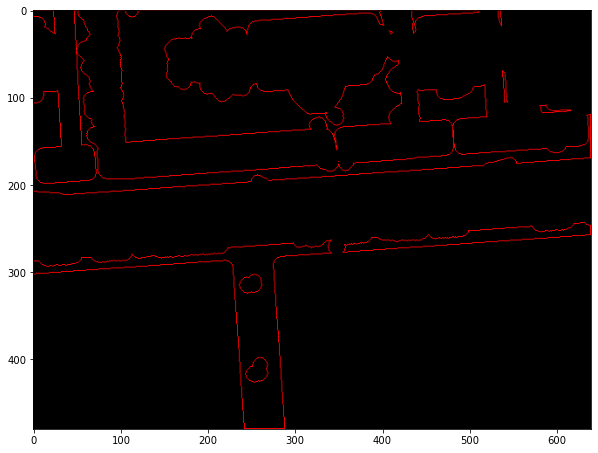

In [21]:
show_contours = np.zeros((view_height,view_width, 3), dtype='uint8')

cv2.drawContours(show_contours, contours, -1, (255,0,0), 1) #cv2.FILLED)
plt.figure(figsize=(10,8))
plt.imshow(show_contours)
plt.show()

In [22]:
# Filter contours according to area
# Calculate objective = area - perimeter/area

filtered_contours = []
for ci,contour in enumerate(contours):
    area = cv2.contourArea(contour)
    if area > 0:
        perimeter = cv2.arcLength(contour,True)
        objective = area - perimeter/area
        #M = cv.moments(contour)
        #cx = int(M['m10']/M['m00'])
        #cy = int(M['m01']/M['m00'])
        
        # It may include obstacles
        filtered_contours.append([ci,objective,area])

filtered_contours = np.array(filtered_contours)
# Normalize (0 to 1)
filtered_contours[:,1] -= filtered_contours[:,1].min()
filtered_contours[:,1] /= filtered_contours[:,1].max()

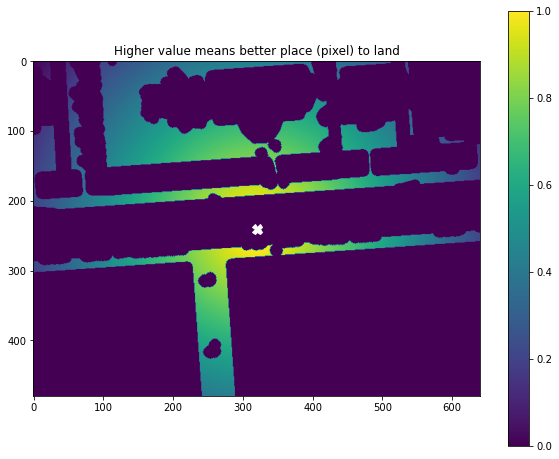

In [23]:
# Option #1
centre_i = view_height/2
centre_j = view_width/2

max_dist = np.sqrt((centre_i)**2+(centre_j)**2)

final_contour = np.zeros((view_height,view_width), dtype='float')
for i,objective,area in filtered_contours:
    ci = int(i)
    contour = contours[ci]
    h = hierarchy[0][ci]
    if h[3]!=-1: # skip children if it's an obstacle
        individual_contour = np.zeros((view_height,view_width), dtype='float')
        cv2.drawContours(individual_contour, [contour], 0, 1, cv2.FILLED)
        matches = np.logical_and(corr_res_thrs,individual_contour).sum()
        if (matches/area)<0.5: # obstacles will won't match the area
            continue
    children = []
    if h[2]!=-1: # it has children
        for k,_,_ in filtered_contours:
            if hierarchy[0][int(k)][3]==ci:
                children.append(int(k))
    
    individual_contour = np.zeros((view_height,view_width), dtype='float')
    cv2.drawContours(individual_contour, [contour], 0, objective, cv2.FILLED)
    
    if children:
        for k in children:
            # Cuts the children from the parent
            cv2.drawContours(individual_contour, [contours[k]], 0, 0, cv2.FILLED)
    
    indices = np.transpose(np.nonzero(individual_contour>0))
    dists = max_dist-np.sqrt(((indices-[centre_i,centre_j])**2).sum(axis=1))
    obstacle_check = 0
    for idx,(r,c) in enumerate(indices):
        individual_contour[r,c] = dists[idx]
        obstacle_check += corr_res_thrs[r,c]
    if len(indices):
        if (obstacle_check/len(indices)) > 0.5:
            final_contour += individual_contour

# Normalize (0 to 1)
final_contour -= final_contour.min()
final_contour /= final_contour.max()

# j = final_contour.max(axis=0).argmax()
# i = final_contour[:,j].argmax()

plt.figure(figsize=(10,8))
plt.imshow(final_contour)
plt.plot([centre_j],[centre_i],'wX', markersize=10)
# plt.plot([j],[i],'r*', markersize=10)
plt.title("Higher value means better place (pixel) to land")
plt.colorbar()
plt.show()